# Project v0.3

## Setup

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [27]:
print(tf.__version__)


2.8.0


### Data path

In [28]:
import pathlib
data_dir = pathlib.Path("./data")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

814


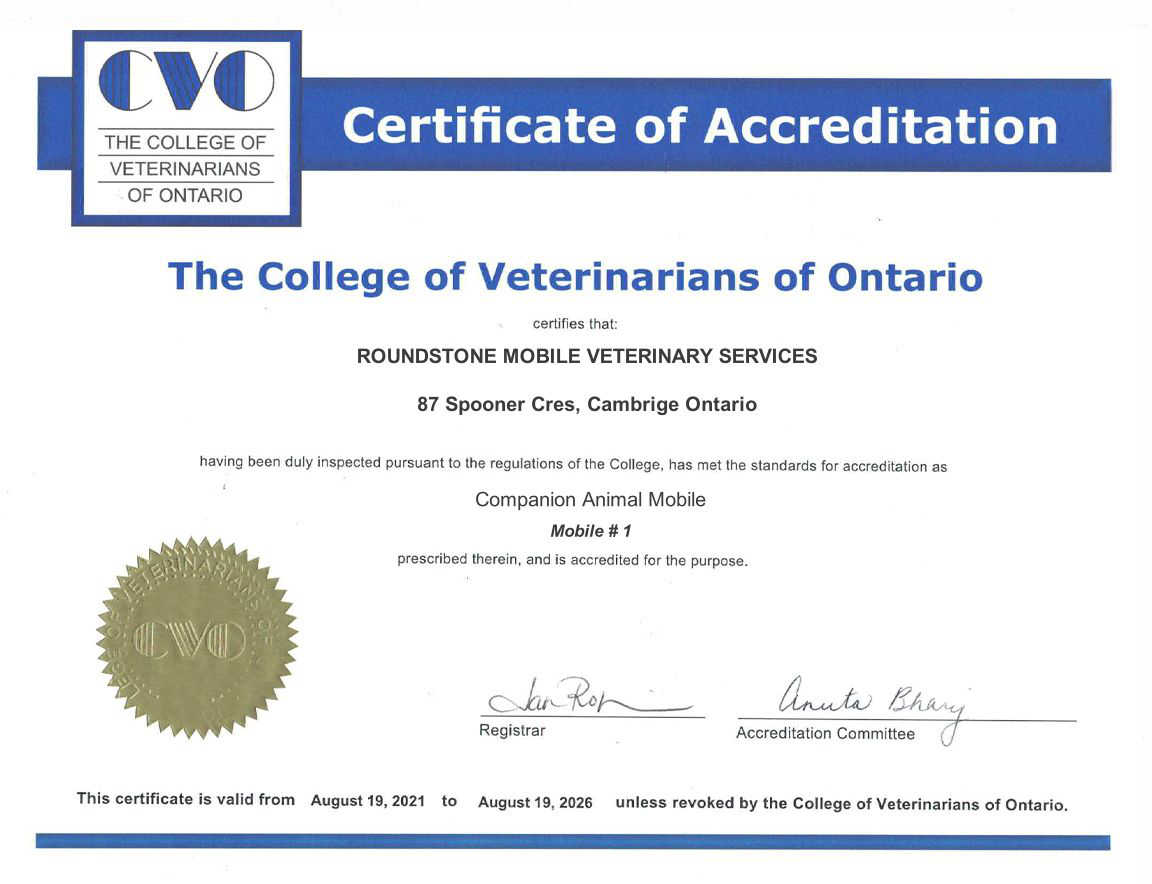

In [29]:
canada_ontario_cvo_imgs = list(data_dir.glob('canada_ontario_cvo/*'))
PIL.Image.open(str(canada_ontario_cvo_imgs[0]))

## Load data using a Keras utility

### Create a dataset

In [30]:
# Define some parameters for the loader:

batch_size = 4
img_height = 100
img_width = 140

In [31]:
# training/validation split

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 814 files belonging to 2 classes.
Using 652 files for training.
Found 814 files belonging to 2 classes.
Using 162 files for validation.


In [32]:
# classes check

class_names = train_ds.class_names
print(class_names)

['canada_ontario_cvo', 'none']


### Data visualization

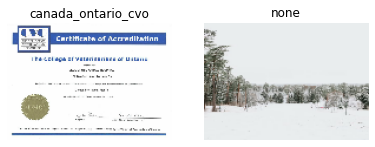

In [33]:
# plot first images from training set

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
# training batches info

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 100, 140, 3)
(4,)


In [35]:
# Data color standardization

normalization_layer = tf.keras.layers.Rescaling(1./255)

### Dataset config for performance

In [36]:
# Cache images to improve performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model training

In [37]:
# Sequential model of three convolution blocks  with a max pooling layer

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
# config to view training and validation accuracy for each training epoch

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [39]:
# model summary

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 100, 140, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 140, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 70, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 70, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 35, 64)       

In [40]:
# training

epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

163/163 [==============================] - 7s 37ms/step - loss: 0.4263 - accuracy: 0.9847 - val_loss: 0.0588 - val_accuracy: 0.9877


### Visualize training results

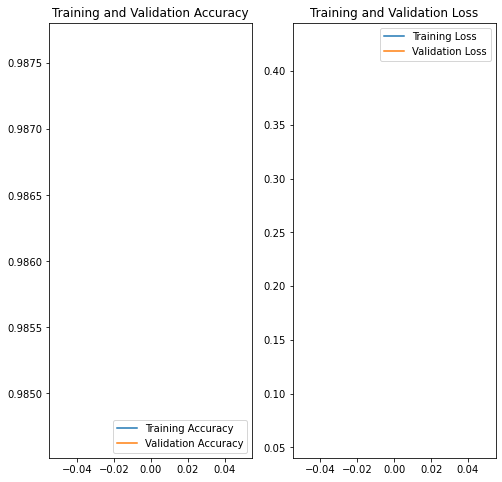

In [41]:
# Create plots of loss and accuracy on the training and validation sets:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## we notice overfitting, let's try to reduce it (could instead increase number of images used in training)

### Data augmentation

In [42]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

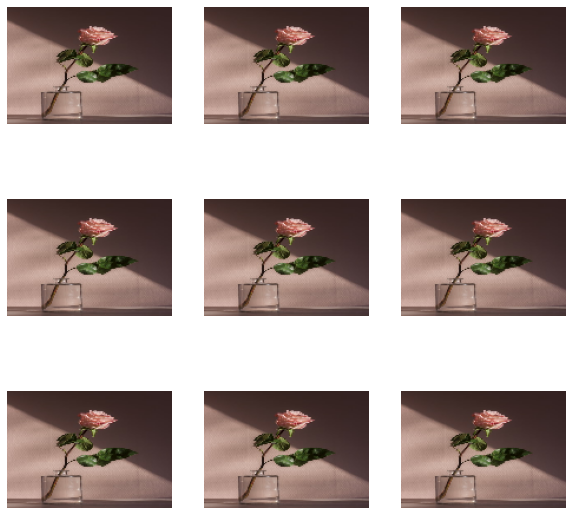

In [43]:
# augmentation example visualization

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

=> probably we should drop data augmentation. needs discussion

### Dropout

In [44]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 100, 140, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 100, 140, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 140, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 70, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 70, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 35, 32)       0         
 g2D)                                                 

In [51]:
class_weight = {0: 5, 1: 0.5}

epochs = 15
history = model.fit(
  train_ds,
  class_weight=class_weight,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
163/163 [==============================] - 5s 33ms/step - loss: 0.0803 - accuracy: 0.9632 - val_loss: 0.0335 - val_accuracy: 0.9815
Epoch 2/15
163/163 [==============================] - 5s 33ms/step - loss: 0.9586 - accuracy: 0.9126 - val_loss: 0.0669 - val_accuracy: 0.9877
Epoch 3/15
163/163 [==============================] - 6s 37ms/step - loss: 0.4506 - accuracy: 0.9755 - val_loss: 0.0994 - val_accuracy: 0.9383
Epoch 4/15
163/163 [==============================] - 6s 38ms/step - loss: 0.0642 - accuracy: 0.9540 - val_loss: 0.0120 - val_accuracy: 0.9938
Epoch 5/15
163/163 [==============================] - 6s 39ms/step - loss: 0.0410 - accuracy: 0.9739 - val_loss: 0.0279 - val_accuracy: 0.9938
Epoch 6/15
163/163 [==============================] - 6s 36ms/step - loss: 0.0421 - accuracy: 0.9724 - val_loss: 0.0114 - val_accuracy: 0.9938
Epoch 7/15
163/163 [==============================] - 6s 36ms/step - loss: 0.0430 - accuracy: 0.9724 - val_loss: 0.0420 - val_accuracy: 0.9753

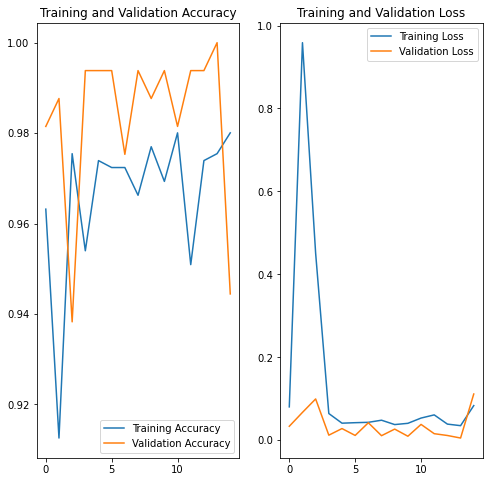

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

still overfitting, we need more data

# let's try and predict on a sunflower image

This image most likely belongs to none with a 100.00 percent confidence.


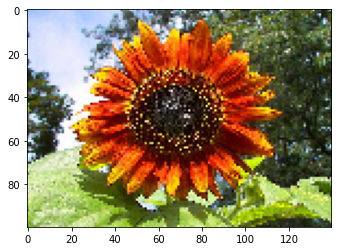

In [53]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# let's try and predict on a valid image

This image most likely belongs to none with a 100.00 percent confidence.


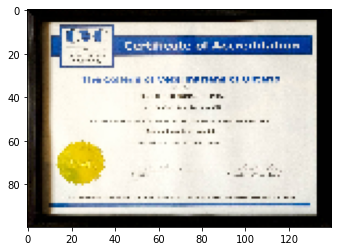

In [58]:
img_path = "./data/canada_ontario_cvo_original1.jpg"

img = tf.keras.utils.load_img(
    "./data/canada_ontario_cvo_original2.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

predication failed miserably xD

probably because unbalanced datasets!